In [2]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import time, os, copy, numpy as np
from livelossplot import PlotLosses
from train_model import train_model
%matplotlib inline

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4801, 0.4481, 0.3978],[0.2255, 0.2222, 0.2212])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4801, 0.4481, 0.3978],[0.2255, 0.2222, 0.2212])        
    ]),
}

data_dir = 'tiny-imagenet-200-224'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=32)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes



In [4]:
#Load Resnet18 with pretrained weights
model_ft = models.resnet18(pretrained=True)
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
#Multi GPU
model_ft = torch.nn.DataParallel(model_ft, device_ids=[0, 1])

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

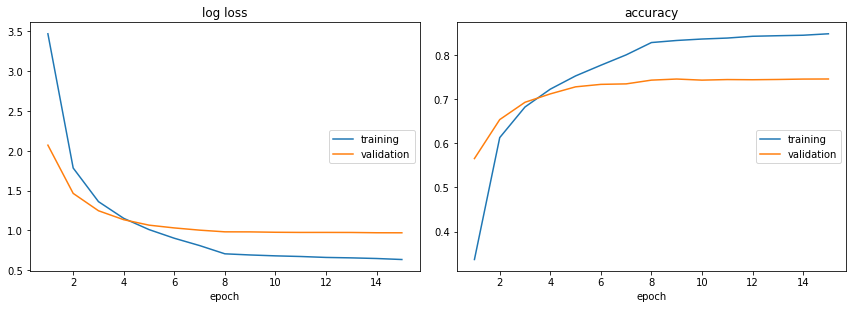


Training complete in 30m 55s
Best val Acc: 0.745900


In [5]:
#Train
model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

In [6]:
# torch.save(model_ft.state_dict(), "./models/resnet18_224.pt") 